<h2> <center><strong>Ecole Polytechnique de Tunisie</strong> </center> </h2> !
<center> <img src="https://nhoues.github.io/Infrastructure-Project/Animations/EPT.jpg" style="width:80px; height:80px"  ></center>


<h1><center>Mini projet conception des systèmes d'information</center></h1>
<h1><em><center>Problème de détection de fraud STEG : Partie d'apprentissage non supervisé </em></center></h1>
<h3><center><em>Réalisé par :</em> <font color='blue'> Naim Houes & Malek Mechergui</font></center></h3> 


# Introduction 

Here we will see about detecting anomalies with time series forcasting. Time series forcasting helps us in preparing us for future needs by estiamting the monthly consumption with the current data. Once we have the forcast we can use that data to detect anomalies on comparing them with actuals.

# Imporations 

In [0]:
!pip install transformers 
!pip install torchcontrib

In [0]:
import os 
from functools import partial
import copy, math
import pandas as pd
from pandas import DataFrame
from pandas import concat
 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time, gc 
import torch 
from torch import nn,optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing  
import transformers 
from tqdm.notebook import tqdm
from torchcontrib.optim import SWA
import torchcontrib


import datetime
from datetime import date
import pandas as pd
import numpy as np
from plotly import __version__

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 



import random

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
tqdm.pandas()

from collections import defaultdict

#Installing specific version of plotly to avoid Invalid property for color error in recent version which needs change in layout
!pip install plotly==2.7.0
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go


%matplotlib inline


In [0]:
µdef configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
## seed everthing 
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load the data

In [0]:
client =pd.read_csv('/content/drive/My Drive/min projet/client_for_semi_supervised.csv')
consumption = pd.read_csv('/content/drive/My Drive/min projet/consumption_for_semi_supervised.csv')
client = client[client['seq_len']>10]

In [5]:
client['Fraud'].value_counts()

0    55612
1     1105
Name: Fraud, dtype: int64

# First Step : consumption forcasting 

in this part , we try forcasting the monthly consumption of each client using LSTM which is a recurrent neural network.

# Data prepartion 

In [6]:
consumption = consumption.set_index('client_id')
consumption = consumption.loc[client['client_id'].unique(),:]
client.head()

,client_id,index,district,client_catg,region,creation,Fraud,how_many_counter,counter_number,end,mean_consumption,start,max_consumption,min_consumption,std_consumption,counter_coefficient,Tarif,seq_len
0,110050,8901,60,51,101,2004-08-10,0,1,124416,2019,4600.844807,2004,14303.00,0.000,1897.136498,1.0,11.0,138
1,110070,46118,60,51,101,2008-08-10,0,1,171147,2019,2745.472222,2008,5487.00,0.000,941.154713,1.0,11.0,93
4,112401,9069,60,11,101,2000-07-20,0,1,300317,2019,441.000000,2000,541.00,185.500,67.418522,1.0,11.0,36
6,112451,9045,60,11,101,2000-07-20,0,1,300115,2019,467.689189,2000,614.25,254.000,70.796710,1.0,11.0,37
7,112501,9105,60,11,101,2000-07-20,0,1,300401,2019,520.219595,2000,687.50,371.125,77.916402,1.0,11.0,37


apply log transform to stabilize the variance in the data or to make it stationary before feeding it to the model.

In [0]:
consumption['consumption_per_month'] = np.log1p(consumption['consumption_per_month'] )

In [0]:
windows = [1,2,3,4,5,6,7,8]
for window in windows:    
  consumption['consumption_shift_neg_' + str(window)] = consumption.groupby('client_id')['consumption_per_month'].shift(window)
  consumption['level_shift_neg_' + str(window)] = consumption.groupby('client_id')['level'].shift(window)
  consumption['quarter_shift_neg_' + str(window)] = consumption.groupby('client_id')['quarter'].shift(window)

In [0]:
cons = ['consumption_shift_neg_' + str(window) for window in range(1,9)]
consumption['mean'] = consumption[cons].mean(axis = 1 )
consumption['std'] =  consumption[cons].std(axis = 1)
consumption['min'] =  consumption[cons].min(axis = 1)
consumption['max'] =  consumption[cons].max(axis = 1)
consumption['var'] =  consumption[cons].var(axis = 1)


In [0]:
consumption = consumption.reset_index()
consumption.drop(consumption[consumption['consumption_shift_neg_8'].isnull()==True].index,inplace=True)

In [0]:
consumption = pd.merge(consumption,client[[ 'client_id','district', 'client_catg', 'region', 'start', 'end','Fraud']],how = 'left',on = 'client_id')

## Dataset class 

In [0]:
fix = ['district', 'client_catg', 'region', 'start', 'end', 'year', 'month', 'quarter','counter_statue', 'counter_coefficient', 'months_number']
num_colmuns = ['mean', 'std', 'min', 'max', 'var', 'consumption_shift_neg_1', 'consumption_shift_neg_2', 'consumption_shift_neg_3']

cons= ['consumption_shift_neg_' + str(window) for window in range(1,9)]
level = ['level_shift_neg_' + str(window) for window in range(1,9)]
quarter = ['quarter_shift_neg_' + str(window) for window in range(1,9)]

In [0]:
for f in fix : 
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(consumption[f].astype('str'))
  consumption[f] = label_encoder.transform(consumption[f].astype('str').fillna('-1'))

In [0]:
for f in num_colmuns : 
  scale = preprocessing.MinMaxScaler()
  scale.fit(consumption[f].values.reshape(-1,1))
  consumption[f] = scale.transform(consumption[f].values.reshape(-1,1))

In [0]:
def get_emb_dim(df,categorical):
    output=[]
    for categorical_var in categorical:

      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
      
      no_of_unique_cat  = df[categorical_var].nunique()
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 32))
      output.append((no_of_unique_cat,embedding_size))    
      print(  
              'Categorica Variable:', categorical_var,
              'Unique Categories:', no_of_unique_cat,
              'Embedding Size:', embedding_size
            
            )
  
      
    return output

In [16]:
entity_dim = get_emb_dim(consumption ,fix)

Categorica Variable: district Unique Categories: 4 Embedding Size: 2
Categorica Variable: client_catg Unique Categories: 3 Embedding Size: 2
Categorica Variable: region Unique Categories: 12 Embedding Size: 6
Categorica Variable: start Unique Categories: 42 Embedding Size: 21
Categorica Variable: end Unique Categories: 14 Embedding Size: 7
Categorica Variable: year Unique Categories: 15 Embedding Size: 8
Categorica Variable: month Unique Categories: 12 Embedding Size: 6
Categorica Variable: quarter Unique Categories: 4 Embedding Size: 2
Categorica Variable: counter_statue Unique Categories: 5 Embedding Size: 3
Categorica Variable: counter_coefficient Unique Categories: 4 Embedding Size: 2
Categorica Variable: months_number Unique Categories: 27 Embedding Size: 14


In [0]:
class Consumption_prediction_dataset() : 
  def __init__(self,df) : 
    out = dict()
    out['target'] = df['consumption_per_month'].values
    out['consumption'] = df[cons].values
    out['hist_level'] = df[level].values
    out['hist_quarter'] = df[quarter].values 
    out['num'] = df[num_colmuns].values  
    for f in fix  : 
      out[f] = df[f].values
    self.df = out
  def __len__(self) : 
    
    return(len(self.df['target']))
  def __getitem__(self,item) : 
    
    out = dict()
    
    for f in fix : 
       out[f] = torch.tensor(self.df[f][item] , dtype= torch.long ) 
   

    out['consumption'] =torch.tensor(self.df['consumption'][item] , dtype = torch.float)
    out['hist_level'] = torch.tensor(self.df['hist_level'][item] ,dtype=torch.long)
    out['hist_quarter'] = torch.tensor(self.df['hist_quarter'][item] ,dtype=torch.long)
    out['num'] = torch.tensor(self.df['num'][item] , dtype = torch.float)

    out['target'] =torch.tensor(self.df['target'][item] , dtype = torch.float)
    return out

In [18]:
consumption.head()

,client_id,counter_number,invoice_date,Tarif,counter_statue,counter_coefficient,months_number,consumption_per_month,level,year,month,quarter,consumption_shift_neg_1,level_shift_neg_1,quarter_shift_neg_1,consumption_shift_neg_2,level_shift_neg_2,quarter_shift_neg_2,consumption_shift_neg_3,level_shift_neg_3,quarter_shift_neg_3,consumption_shift_neg_4,level_shift_neg_4,quarter_shift_neg_4,consumption_shift_neg_5,level_shift_neg_5,quarter_shift_neg_5,consumption_shift_neg_6,level_shift_neg_6,quarter_shift_neg_6,consumption_shift_neg_7,level_shift_neg_7,quarter_shift_neg_7,consumption_shift_neg_8,level_shift_neg_8,quarter_shift_neg_8,mean,std,min,max,var,district,client_catg,region,start,end,Fraud
0,110050,124416,2007-03-04,11,0,0,0,8.851377,1,2,7,0,0.728995,1.0,0.0,0.745830,1.0,0.0,0.775624,1.0,0.0,8.862873,1.0,0.0,8.455318,1.0,2.0,8.561354,1.0,1.0,8.481203,1.0,0.0,8.361825,1.0,2.0,0.774324,0.055814,0.760687,0.764088,0.003115,0,2,0,27,13,0
1,110050,124416,2007-03-05,11,0,0,0,8.975504,1,2,7,0,0.745217,1.0,0.0,0.728995,1.0,0.0,0.745830,1.0,0.0,9.212538,1.0,0.0,8.862873,1.0,0.0,8.455318,1.0,2.0,8.561354,1.0,1.0,8.481203,1.0,0.0,0.779782,0.050347,0.769192,0.764088,0.002535,0,2,0,27,13,0
2,110050,124416,2007-03-07,11,0,0,0,9.147933,1,2,7,0,0.755668,1.0,0.0,0.745217,1.0,0.0,0.728995,1.0,0.0,8.858653,1.0,0.0,9.212538,1.0,0.0,8.862873,1.0,0.0,8.455318,1.0,2.0,8.561354,1.0,1.0,0.785293,0.047785,0.769192,0.764088,0.002283,0,2,0,27,13,0
3,110050,124416,2007-04-06,11,0,0,0,8.993427,1,2,8,1,0.770185,1.0,0.0,0.755668,1.0,0.0,0.745217,1.0,0.0,8.658693,1.0,0.0,8.858653,1.0,0.0,9.212538,1.0,0.0,8.862873,1.0,0.0,8.455318,1.0,2.0,0.791833,0.048703,0.769192,0.764088,0.002372,0,2,0,27,13,0
4,110050,124416,2007-04-09,11,0,0,0,8.690978,1,2,8,1,0.757177,1.0,1.0,0.770185,1.0,0.0,0.755668,1.0,0.0,8.851377,1.0,0.0,8.658693,1.0,0.0,8.858653,1.0,0.0,9.212538,1.0,0.0,8.862873,1.0,0.0,0.797832,0.035227,0.787693,0.764088,0.001241,0,2,0,27,13,0


## First step Model 

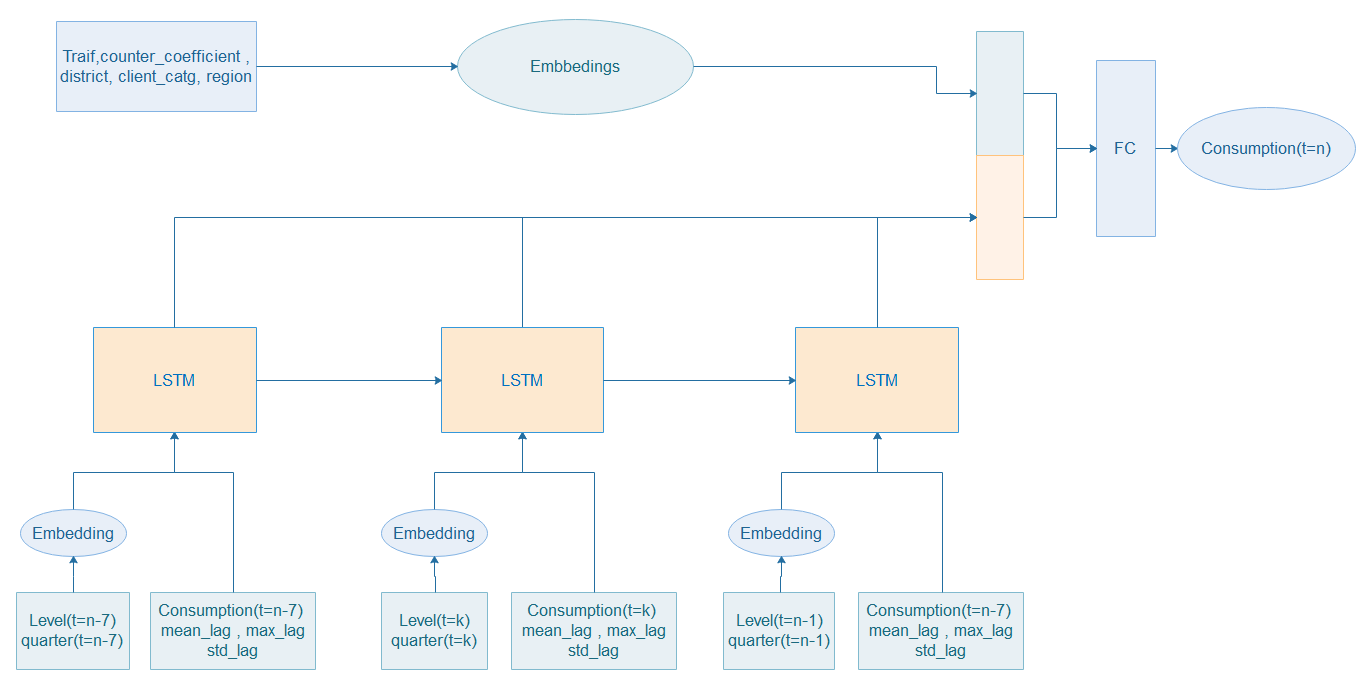

In [0]:
class consumption_forcaster(nn.Module) : 
  def __init__(self,emb_size) : 
    
    super(consumption_forcaster,self).__init__() 

    self.embedding_level = nn.Embedding(5, 2)
    self.embedding_quarter = nn.Embedding(5, 2)

    self.rnn = nn.GRU( 4+1 , 256 , bidirectional =True)


    outputs_cat = nn.ModuleList() # define the Embedding layer
    for inp , emb  in emb_size :
        embedding_layer = nn.Embedding(inp+2,emb)
        outputs_cat.append(embedding_layer)
    self.outputs_cat = outputs_cat 
    
    n_emb = sum([e[1] for e in emb_size]) 
    
    self.fc = nn.Sequential(  
                              nn.Linear( n_emb + 256 *2 + len(num_colmuns) ,512),
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.05),
                              nn.ReLU(),
                              nn.Linear( 512 ,256),
                              nn.BatchNorm1d(256),
                              nn.Dropout(0.01),
                              nn.ReLU(),
                              nn.Linear(256,1)
                            )



  def forward(self,data) :
    
    x_cat = []
    x = data['hist_level'].to(device,dtype=torch.long) 
    x = x.permute(1,0)
    x =  self.embedding_level(x) 
    x_cat.append(x)
    
    x = data['hist_quarter'].to(device,dtype=torch.long) 
    x = x.permute(1,0)
    x =  self.embedding_quarter(x) 
    x_cat.append(x)

    x_cat = torch.cat(x_cat,axis=2)



    x_num = data['consumption'].to(device,dtype=torch.float) 
    x_num = x_num.permute(1,0)
    x_num = x_num.unsqueeze(2)


    embedded = torch.cat( [ x_num , x_cat ] ,axis = 2 )
   
    output, hidden = self.rnn(embedded) 
 
    x_seq = torch.cat([hidden[-1,:,:],hidden[-2,:,:]],axis = 1 )
      
      
    outputs_emb = [] 
    for i in range(len(fix)) : 
        inputs = data[fix[i]].to(device,dtype=torch.long) 
        out = self.outputs_cat[i](inputs)
        outputs_emb.append(out.squeeze(1)) 
    x_cat = torch.cat(outputs_emb,dim= 1)
    x_num =  data["num"].to(device,dtype=torch.float) 
    x_all = torch.cat([x_cat,x_seq,x_num],dim=1)

    x_out = self.fc(x_all).to(device,dtype=torch.float) 
    return x_out 

## Engine 

In [0]:
def loss_fn(outputs, targets):
    return nn.MSELoss()(outputs, targets.view(-1,1))

In [0]:
def train_fn(data_loader, model, optimizer, schedular):
  model.train()
  
  train_losses =[]


  for bi , d in tqdm(enumerate(data_loader), total=len(data_loader)):
    
    targets = d["target"]
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()
    
    outputs = model(d)
    
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())


     
  return train_losses

In [0]:
def eval_fn(data_loader, model):
  model.eval()
  
  valid_losses=[]

  
  with torch.no_grad():
   
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      targets = d["target"]
      targets = targets.to(device, dtype=torch.float)
        
      outputs = model(d)
    
     
      loss = loss_fn(outputs, targets)
      
      valid_losses.append(loss.item())

    
    return valid_losses

In [0]:
def run(model):#42
    it = 1 
    
    train_dataloader = DataLoader(
                                  train_dataset,
                                  batch_size=NNBATCHSIZE,
                                 
                                  pin_memory=False,
                                  drop_last=False,
                                  num_workers=2
                              )

    valid_dataloader = DataLoader(valid_dataset, NNBATCHSIZE, shuffle=False)

    it = 0
    
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(train_dataloader)) * EPOCHS
    optimizer = AdamW(optimizer_parameters, lr=LR)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    
    avg_train_losses, avg_valid_losses = [], []
 
    
    for epoch in range(EPOCHS):
      start_time = time.time()
      print('**********************************')
      print("Curr learning_rate: {:0.9f}".format(optimizer.param_groups[0]['lr']))
      train_losses = train_fn(train_dataloader, model, optimizer, scheduler)
      train_loss = np.average(train_losses)
      avg_train_losses.append(train_loss)
  
      print( "train_loss: {:0.9f}".format(np.sqrt(train_loss)))    
      
      valid_losses = eval_fn(valid_dataloader, model)
      valid_loss = np.average(valid_losses)
      avg_valid_losses.append(valid_loss)
      print( "valid_loss: {:0.9f}".format(np.sqrt(valid_loss)))
  
      
      print("--- %s seconds ---" % (time.time() - start_time))
    return avg_train_losses,avg_valid_losses

# Training step 1 : 

In [0]:
#train test split 
from sklearn.model_selection import train_test_split
client = client.set_index('client_id')
client = client.loc[consumption['client_id'].unique(),:]
train,test = train_test_split(client, test_size=0.1, random_state=42, stratify=client['Fraud'])

In [0]:
consumption_train = consumption.set_index('client_id')
consumption_train = consumption_train.loc[train.index,:]

In [0]:
df_train , df_valid = train_test_split(consumption_train, test_size=0.2, random_state=42)

In [0]:
NNBATCHSIZE = 2048 
EPOCHS = 20
LR = 1e-3
device = torch.device('cuda')

In [0]:
train_dataset = Consumption_prediction_dataset(df_train)
valid_dataset = Consumption_prediction_dataset(df_valid)

In [29]:
model = consumption_forcaster(entity_dim)
model = model.to(device)
resualts = run(model)

**********************************
Curr learning_rate: 0.001000000



train_loss: 1.174269009



valid_loss: 0.855021758
--- 148.69041228294373 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.846986806



valid_loss: 0.853670605
--- 151.08611249923706 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.839726978



valid_loss: 0.844868805
--- 151.04505372047424 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.834540734



valid_loss: 0.839637498
--- 150.584534406662 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.830034926



valid_loss: 0.835342298
--- 151.55792617797852 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.826287490



valid_loss: 0.833892960
--- 150.22148752212524 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.822831585



valid_loss: 0.830830770
--- 151.90945100784302 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.819569565



valid_loss: 0.829717538
--- 151.97064781188965 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.816779639



valid_loss: 0.828150558
--- 151.50577092170715 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.814066402



valid_loss: 0.828244748
--- 149.88299322128296 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.811153761



valid_loss: 0.827642450
--- 151.55864644050598 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.808486501



valid_loss: 0.827292295
--- 152.4578833580017 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.805340888



valid_loss: 0.827932758
--- 150.46696591377258 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.802549195



valid_loss: 0.827227718
--- 148.6822326183319 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.799560164



valid_loss: 0.827614114
--- 148.2656171321869 seconds ---
**********************************
Curr learning_rate: 0.001000000



train_loss: 0.796143231



valid_loss: 0.828578442
--- 149.08214139938354 seconds ---
**********************************
Curr learning_rate: 0.001000000


KeyboardInterrupt: ignored

In [0]:
def predict(data_loader, model):
  model.eval()
  
  predicted = []
  fin_outputs = []
  
  with torch.no_grad():
   
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        
      outputs = model(d)
      outputs_np = outputs.cpu().detach().numpy().tolist()
      fin_outputs.extend(outputs_np)  

    
    return fin_outputs

In [31]:
consumption_dataset = Consumption_prediction_dataset(consumption_train)
dataloader = DataLoader(consumption_dataset, NNBATCHSIZE, shuffle=False)
pred = predict(dataloader,model)
consumption_train['pred'] = pred 
def first(x) : 
  return x[0] 
consumption_train['pred']  = consumption_train['pred'].apply(first)

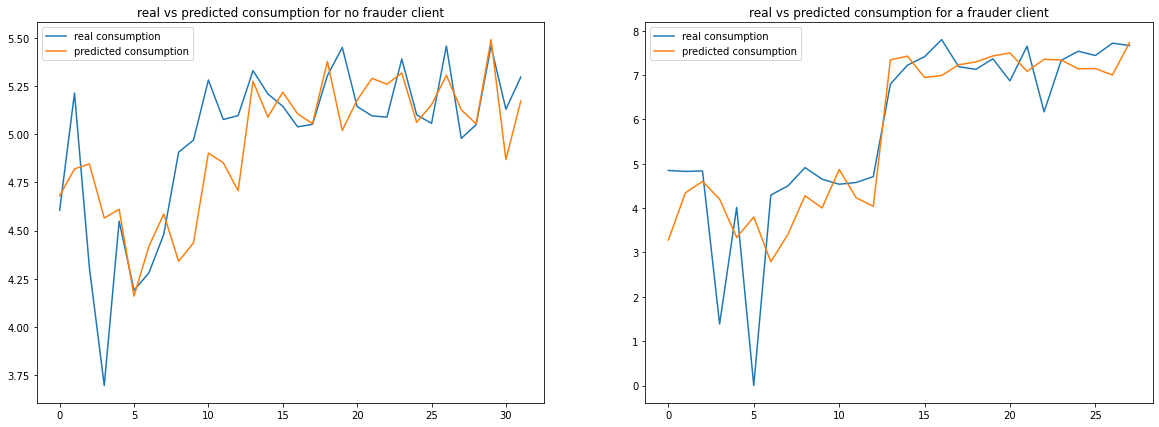

In [153]:
figsize=(20, 7)
plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(consumption_train[consumption_train['counter_number']=='346571']['consumption_per_month'].values , label = 'real consumption')
plt.plot(consumption_train[consumption_train['counter_number']=='346571']['pred'].values, label ='predicted consumption' )
plt.legend()
plt.title('real vs predicted consumption for no frauder client') 
plt.subplot(122)

plt.plot(consumption_train[consumption_train['counter_number']=='612807']['consumption_per_month'].values , label = 'real consumption')
plt.plot(consumption_train[consumption_train['counter_number']=='612807']['pred'].values, label ='predicted consumption' )
plt.legend()
plt.title('real vs predicted consumption for a frauder client') 
plt.show()

## Step 2 : Anomaly  Detection 


We have results of forecast and actuals, to detect anomalies using this information, we are using a property of the distribution of data. 
Steps I do to detect anomalies:
1. Compute the error term(actual- predicted).
2. Compute the rolling mean and rolling standard deviation(window is a week).
3. Classify data with an error of 1.5,1.75 and 2 standard deviations as limits for low,medium and high anomalies. 

In [79]:
def detect_classify_anomalies(df,window):


    df['error']=df['consumption_per_month']-df['pred']
    df['percentage_change'] = ((df['consumption_per_month'] - df['pred']) / df['consumption_per_month']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
 
    return df

Below is a fucntion to visualize the results.

In [86]:
configure_plotly_browser_state()

In [136]:
def plot_anomaly(df,metric_name):
    
    dates = df.index
 
    bool_array = (abs(df['anomaly_points']) > 0)
#And a subplot of the Actual Values.
    actuals = df["consumption_per_month"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
#Order_results['meanval']=meanval
    #Order_results['deviation']=deviation
    color_map= {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2 ],
    #columnorder=[0, 1, 2,],
    header = dict(height = 20,
                  values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                            ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                 font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                  fill = dict(color='#d562be')),
    cells = dict(values = [df.round(3)[k].tolist() for k in ['invoice_date', 'consumption_per_month', 'pred',
                                                               'percentage_change','color']],
                 line = dict(color='#506784'),
                 align = ['center'] * 5,
                 font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                
                 suffix=[None] + [''] + [''] + ['%'] + [''],
                 height = 27,
                 fill=dict(color=  #
                      [df['color'].map(color_map)],
                      )
    ))
  #df['ano'] = np.where(df['color']==3, df['error'], np.nan)
    anomalies = go.Scatter(name="Anomaly",
                       x=dates,
                       xaxis='x1',
                       yaxis='y1',
                       y=df['anomaly_points'],
                       mode='markers',
                       marker = dict(color ='red',
                      size = 11,line = dict(
                                         color = "red",
                                         width = 2)))
    upper_bound = go.Scatter(hoverinfo="skip",
                         x=dates,
                         showlegend =False,
                         xaxis='x1',
                         yaxis='y1',
                         y=df['3s'],
                         marker=dict(color="#444"),
                         line=dict(
                             color=('rgb(23, 96, 167)'),
                             width=2,
                             dash='dash'),
                         fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty')
    lower_bound = go.Scatter(name='Confidence Interval',
                          x=dates,
                         xaxis='x1',
                         yaxis='y1',
                          y=df['-3s'],
                          marker=dict(color="#444"),
                          line=dict(
                              color=('rgb(23, 96, 167)'),
                              width=2,
                              dash='dash'),
                          fillcolor='rgba(68, 68, 68, 0.3)',
                          fill='tonexty')
    Actuals = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= df['consumption_per_month'],
                    xaxis='x2', yaxis='y2',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    Predicted = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= df['pred'],
                    xaxis='x2', yaxis='y2',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="orange"))
# create plot for error...
    Error = go.Scatter(name="Error",
                   x=dates, y=df['error'],
                   xaxis='x1',
                   yaxis='y1',
                   mode='line',
                   marker=dict(size=12,
                               line=dict(width=1),
                               color="red"),
                   text="Error")
    anomalies_map = go.Scatter(name = "anomaly actual",
                                   showlegend=False,
                                   x=dates,
                                   y=anomaly_points,
                                   mode='markers',
                                   xaxis='x2',
                                   yaxis='y2',
                                    marker = dict(color ="red",
                                  size = 11,
                                 line = dict(
                                     color = "red",
                                     width = 2)))
    Mvingavrg = go.Scatter(name="Moving Average",
                           x=dates,
                           y=df['meanval'],
                           mode='line',
                           xaxis='x1',
                           yaxis='y1',
                           marker=dict(size=12,
                                       line=dict(width=1),
                                       color="green"),
                           text="Moving average")
    axis=dict(
    showline=True,
    zeroline=False,
    showgrid=True,
    mirror=True,
    ticklen=4,
    gridcolor='#ffffff',
    tickfont=dict(size=10))
    layout = dict(
    width=1000,
    height=865,
    autosize=False,
    title= metric_name,
    margin = dict(t=75),
    showlegend=True,
    xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
    xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
    yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
    yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f')))
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                        upper_bound,lower_bound,Actuals,Predicted,
                        Mvingavrg,Error], layout = layout)
    iplot(fig)
    pyplot.show()
    plt.show()

classify_df=detect_classify_anomalies(consumption_train[consumption_train['counter_number']=='346571'].reset_index(),7)

classify_df.reset_index(inplace=True)

plot_anomaly(classify_df.iloc[7:].reset_index(drop=True),"metric_name")


In [156]:
classify_df=detect_classify_anomalies(consumption_train[consumption_train['counter_number']=='612807'].reset_index(),7)

classify_df.reset_index(inplace=True)

plot_anomaly(classify_df.iloc[3:].reset_index(drop=True),"metric_name")
